## Modeling for predicting 72h ED revisit at ED disposition

Flow:
1. task-specific filter: exclude ED death cases for train and test
2. variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
import pandas as pd
import os
from helpers import PlotROCCurve
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

#path = 'C:/Users/XFE/Documents/mimic4ed-benchmark/data_processed/'
#path = '/home/jun/data/MIMIC/mimiciv/1.0/processed'
path = '/home/logasan/mimic4ed-benchmark/Benchmark_scripts/processed/'

df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 0.95


In [2]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 
df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_death,before_ed_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,...,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,215414,18566742,27103162.0,38538786,2135-07-16 16:08:00,2135-07-17 01:49:00,58,F,2132,NaN,2135-07-17 00:20:00,2135-07-18 18:20:00,NaN,HISPANIC/LATINO,2135-07-16 16:08:00,2135-07-17 01:49:00,Other,2135,61,False,False,False,0 days 09:41:00,NaN,NaN,False,True,False,0,0,0,2136-07-30 17:08:00,379 days 15:19:00,False,0,0,0,0,0,0,9.68,NaN,379.64,37.166667,93.0,16.0,100.0,160.0,66.0,4.167576,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.760621,78.220568,17.260731,98.141378,127.427849,73.556876,2.127651,5.0,2.0,97.333333,2,4,3,1,1,1
1,205452,16853729,NaN,30043998,2178-01-25 05:09:00,2178-01-25 07:05:00,91,F,2169,NaN,NaN,NaN,NaN,OTHER,NaN,NaN,NaN,2178,100,False,False,False,0 days 01:56:00,NaN,NaN,False,False,False,0,1,7,2178-03-11 09:43:00,45 days 02:38:00,False,0,0,5,0,0,0,1.93,NaN,45.11,36.666667,76.0,20.0,95.0,165.0,95.0,4.167576,...,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,36.777778,75.000000,18.000000,97.000000,133.000000,80.000000,2.127651,2.0,3.0,118.333333,7,9,8,1,0,1
2,200705,16026698,NaN,39475313,2128-10-19 20:01:00,2128-10-19 20:16:00,23,M,2128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2128,23,False,False,False,0 days 00:15:00,NaN,NaN,False,False,False,0,0,1,2129-01-05 21:12:00,78 days 00:56:00,False,0,0,0,0,0,0,0.25,NaN,78.04,37.222222,125.0,22.0,99.0,156.0,96.0,7.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.833333,95.000000,18.000000,100.000000,143.000000,82.000000,7.000000,1.0,1.0,116.000000,0,12,4,4,4,4
3,87038,15398519,25237915.0,35495155,2147-06-15 09:50:00,2147-06-15 15:55:00,57,M,2136,NaN,2147-06-15 14:00:00,2147-06-16 16:45:00,NaN,BLACK/AFRICAN AMERICAN,2147-06-15 09:50:00,2147-06-15 15:55:00,Medicare,2147,68,False,False,False,0 days 06:05:00,NaN,NaN,False,True,False,0,2,5,2147-07-01 10:46:00,15 days 18:51:00,False,0,2,5,0,0,1,6.08,NaN,15.79,37.166667,110.0,22.0,92.0,122.0,89.0,7.000000,...,0,0,1,0,1,1,1,0,1,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,36.777778,106.000000,20.000000,92.000000,96.000000,75.000000,0.000000,7.0,10.0,100.000000,12,16,7,5,3,3
4,373626,16787687,23674090.0,31087259,2181-03-20 10:38:00,2181-03-21 12:55:00,87,F,2176,NaN,2181-03-20 22:01:00,2181-03-21 12:55:00,NaN,BLACK/AFRICAN AMERICAN,2181-03-20 10:38:00,2181-03-21 12:55:00,Medicare,2181,92,False,False,False,1 days 02:17:00,NaN,NaN,False,True,False,0,0,2,2181-04-06 09:43:00,15 days 20:48:00,False,0,0,2,0,0,0,26.28,NaN,15.87,37.111111,90.0,14.0,99.0,125.0,68.0,3.000000,...,0,0,0,1,0,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,36.666667,74.000000,18.000000,98.000000,100.000000,59.000000,0.000000,6.0,13.0,87.000000,11,9,6,0,0,0


In [3]:
#revise time range + function name

### 1. task-specific filter: exclude ED death cases for train and test

In [4]:
df_train = df_train[(df_train['before_ed_mortality'] == False) & (df_train['outcome_hospitalization'] == False) & (df_train['ed_death'] == False)]
df_test = df_test[(df_test['before_ed_mortality'] == False) & (df_test['outcome_hospitalization'] == False) & (df_test['ed_death'] == False)]

### 2. Variable Selection

In [5]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache", 
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope",
            "chiefcom_dizziness",
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", "cci_Pulmonary", 
            "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", "cci_DM2", 
            "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", "cci_Cancer2", 
            "cci_HIV",
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2",  
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss", 
            "eci_Anemia", "eci_Alcohol", "eci_Drugs", "eci_Psychoses", "eci_Depression",
            
            "ed_temperature_last", "ed_heartrate_last", "ed_resprate_last", 
            "ed_o2sat_last", "ed_sbp_last", "ed_dbp_last", "ed_los", "n_med", "n_medrecon"]

outcome = "outcome_ed_revisit_3d"

In [6]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [7]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_los,n_med,n_medrecon
0,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,object,float64,float64


In [8]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [9]:
X_train['ed_los'] = pd.to_timedelta(X_train['ed_los']).dt.seconds / 60
X_test['ed_los'] = pd.to_timedelta(X_test['ed_los']).dt.seconds / 60

In [10]:
print('class ratio')
print('positive : negative =', y_train.sum()/(~y_train).sum(), ': 1')

class ratio
positive : negative = 0.047332185886402756 : 1


### 3.  Modeling script

In [11]:
# Containers for all results
result_list = []

In [12]:
# Hyperparameter tuning for Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=10000)
para_grid = [
    {'penalty' : ['l1', 'l2', 'elasticnet'],
    'C' : [100,10,1,0.1,0.01],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }
]

clf = GridSearchCV(logreg,param_grid=para_grid,cv=3,verbose=1,n_jobs=-1)
best_clf = clf.fit(X_train,y_train)
best_clf.best_estimator_

Fitting 3 folds for each of 75 candidates, totalling 225 fits


/home/logasan/mimic4ed-benchmark/MyDemoEnv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 225.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/logasan/mimic4ed-benchmark/MyDemoEnv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/logasan/mimic4ed-benchmark/MyDemoEnv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/logasan/mimic4ed-benchmark/MyDemoEnv/lib

LogisticRegression(C=0.01, max_iter=10000)

Logistic Regression:
Training time: 43.10851979255676 seconds
AUC: 0.6892570045243608
AUPRC: 0.16978203426813854
Sensitivity: 0.5702031602708804
Specificity: 0.7096298283261803
Score thresold: 0.4764080322321642
2.5 97.5


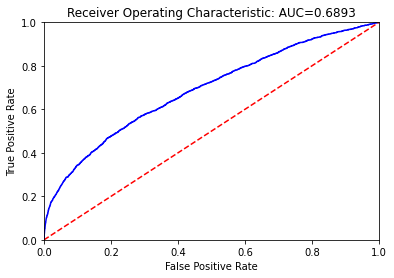

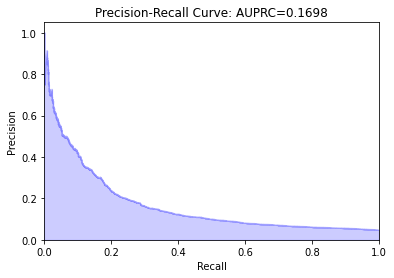

In [13]:
print("Logistic Regression:")
logreg=LogisticRegression(C=0.01, class_weight='balanced', max_iter=10000)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



MLP:
Training time: 115.29618406295776 seconds
AUC: 0.6894383644645526
AUPRC: 0.17042646888578142
Sensitivity: 0.6135440180586907
Specificity: 0.650773426323319
Score thresold: 0.05278734678742315
2.5 97.5


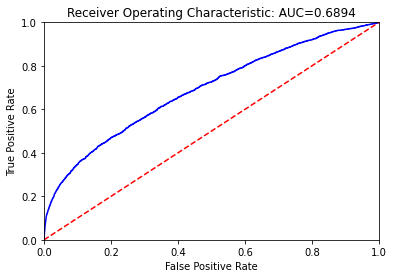

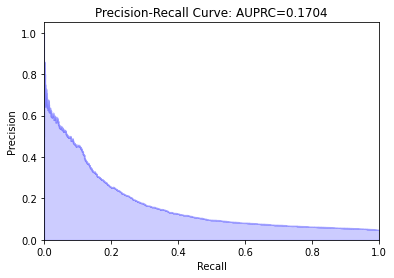

In [14]:
print("MLP:")
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
start = time.time()
mlp.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = mlp.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)

results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)


In [15]:
# Hyperparameter tuning for RandomForest
from sklearn.ensemble import RandomForestClassifier

rf= RandomForestClassifier(n_jobs=-1)
para_grid = [
    {'max_features' : ['auto','sqrt','log2'],
    'n_estimators' : [100,200,400,600,800,1000,1200,1400,1600,1800,2000],
    'max_depth' : [10,20,30,40,50,60,70,80,90,100]
    }
]

clf = RandomizedSearchCV(estimator=rf,param_distributions=para_grid,cv=3,verbose=2)
best_clf = clf.fit(X_train,y_train)
best_clf.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ..max_depth=70, max_features=log2, n_estimators=600; total time=  11.4s
[CV] END ..max_depth=70, max_features=log2, n_estimators=600; total time=  11.1s
[CV] END ..max_depth=70, max_features=log2, n_estimators=600; total time=  10.9s
[CV] END ..max_depth=40, max_features=auto, n_estimators=400; total time=   8.5s
[CV] END ..max_depth=40, max_features=auto, n_estimators=400; total time=   8.4s
[CV] END ..max_depth=40, max_features=auto, n_estimators=400; total time=   8.4s
[CV] END .max_depth=60, max_features=log2, n_estimators=1600; total time=  27.7s
[CV] END .max_depth=60, max_features=log2, n_estimators=1600; total time=  28.0s
[CV] END .max_depth=60, max_features=log2, n_estimators=1600; total time=  27.9s
[CV] END .max_depth=100, max_features=auto, n_estimators=200; total time=   4.6s
[CV] END .max_depth=100, max_features=auto, n_estimators=200; total time=   4.7s
[CV] END .max_depth=100, max_features=auto, n_es

{'n_estimators': 400, 'max_features': 'auto', 'max_depth': 40}

RandomForest:
Training time: 103.03196239471436 seconds
AUC: 0.6601173839118767
AUPRC: 0.14636205635977023
Sensitivity: 0.5521444695259594
Specificity: 0.6836105150214593
Score thresold: 0.0546711509715994
2.5 97.5


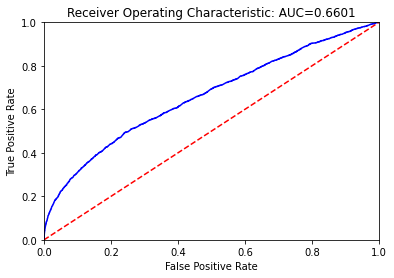

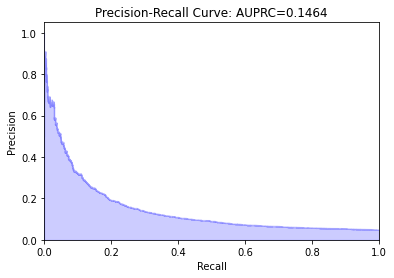

[0.08285047 0.0144815  0.0209034  0.02749538 0.03826282 0.00728466
 0.01241033 0.02126405 0.00070729 0.00128736 0.00262692 0.04959936
 0.02369457 0.00571602 0.00853912 0.00591389 0.00012246 0.0058798
 0.00276295 0.003593   0.00307815 0.00208629 0.0032754  0.00214574
 0.00236612 0.00216828 0.00222952 0.00091642 0.00566246 0.00154108
 0.00121668 0.00369359 0.00455425 0.00209412 0.00082381 0.00239017
 0.00278497 0.00077308 0.00124015 0.0009107  0.00470894 0.00199622
 0.00185427 0.0023683  0.00751299 0.00373399 0.00337703 0.00064133
 0.0028881  0.00415842 0.00223987 0.0069415  0.00080314 0.00311808
 0.00840443 0.00667842 0.00249102 0.00676429 0.06593636 0.0785728
 0.0351578  0.03891745 0.07781499 0.07554828 0.08038681 0.0430919
 0.05254693]


In [16]:
print("RandomForest:")
rf= RandomForestClassifier(class_weight='balanced', n_estimators=400, max_features='auto', max_depth=40)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [17]:
# Hyperparameter tuning for Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
para_grid = [
    {'learning_rate' : [0.01,0.1,1,10,100],
    'n_estimators' : [5,50,250,500],
    'max_depth' : [1,3,5,7,9],
    }
]

clf = RandomizedSearchCV(estimator=gb,param_distributions=para_grid,cv=3,verbose=2)
best_clf = clf.fit(X_train,y_train)
best_clf.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ......learning_rate=10, max_depth=9, n_estimators=5; total time=   3.8s
[CV] END ......learning_rate=10, max_depth=9, n_estimators=5; total time=   3.7s
[CV] END ......learning_rate=10, max_depth=9, n_estimators=5; total time=   3.7s
[CV] END ...learning_rate=100, max_depth=3, n_estimators=250; total time=  51.5s
[CV] END ...learning_rate=100, max_depth=3, n_estimators=250; total time=  51.0s
[CV] END ...learning_rate=100, max_depth=3, n_estimators=250; total time=  51.5s
[CV] END ....learning_rate=0.1, max_depth=1, n_estimators=50; total time=   3.8s
[CV] END ....learning_rate=0.1, max_depth=1, n_estimators=50; total time=   3.9s
[CV] END ....learning_rate=0.1, max_depth=1, n_estimators=50; total time=   3.8s
[CV] END .....learning_rate=100, max_depth=9, n_estimators=5; total time=   3.7s
[CV] END .....learning_rate=100, max_depth=9, n_estimators=5; total time=   3.7s
[CV] END .....learning_rate=100, max_depth=9, n_

{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01}

GradientBoosting:
Training time: 159.12466478347778 seconds
AUC: 0.6910149677707915
AUPRC: 0.17390115943695034
Sensitivity: 0.6031602708803612
Specificity: 0.6642748569384835
Score thresold: 0.03850851121387442
2.5 97.5


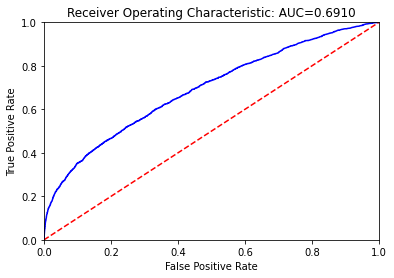

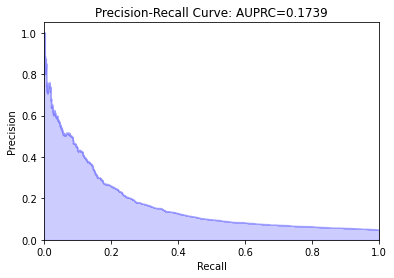

In [18]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=500,max_depth=3,learning_rate=0.01)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [19]:
# Temporal skip
'''
print("Support Vector Machine:")
from sklearn.svm import SVC
svc=SVC()
start = time.time()
svc.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = svc.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["SVM"]
results.extend(result)
results.append(runtime)
result_list.append(results)
'''

'\nprint("Support Vector Machine:")\nfrom sklearn.svm import SVC\nsvc=SVC()\nstart = time.time()\nsvc.fit(X_train,y_train)\nruntime = time.time()-start\nprint(\'Training time:\', runtime, \'seconds\')\nprobs = svc.predict_proba(X_test)\nresult = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)\n\nresults = ["SVM"]\nresults.extend(result)\nresults.append(runtime)\nresult_list.append(results)\n'

### 4. Performance output

In [20]:
#result_df = pd.read_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'))
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'), index=False)
result_df

,Model,auroc,ap,sensitivity,specificity,threshold,lower_auroc,upper_auroc,std_auroc,lower_ap,upper_ap,std_ap,lower_sensitivity,upper_sensitivity,std_sensitivity,lower_specificity,upper_specificity,std_specificity,runtime
0,LR,0.689257,0.169782,0.570203,0.709630,0.476408,0.677251,0.700570,0.006208,0.152943,0.185700,0.007796,0.558825,0.630301,0.017897,0.630964,0.721020,0.023163,43.108520
1,MLP,0.689438,0.170426,0.613544,0.650773,0.052787,0.676745,0.700396,0.006121,0.154828,0.185798,0.008226,0.583047,0.647738,0.015857,0.620401,0.685167,0.016628,115.296184
2,RF,0.660117,0.146362,0.552144,0.683611,0.054671,0.646911,0.673195,0.006780,0.132762,0.159822,0.007171,0.522829,0.599930,0.020274,0.636193,0.716007,0.025213,103.031962
3,GB,0.691015,0.173901,0.603160,0.664275,0.038509,0.679589,0.703233,0.006102,0.157260,0.190216,0.008179,0.588705,0.636969,0.013772,0.635260,0.677357,0.013728,159.124665


In [21]:
result_df

,Model,auroc,ap,sensitivity,specificity,threshold,lower_auroc,upper_auroc,std_auroc,lower_ap,upper_ap,std_ap,lower_sensitivity,upper_sensitivity,std_sensitivity,lower_specificity,upper_specificity,std_specificity,runtime
0,LR,0.689257,0.169782,0.570203,0.709630,0.476408,0.677251,0.700570,0.006208,0.152943,0.185700,0.007796,0.558825,0.630301,0.017897,0.630964,0.721020,0.023163,43.108520
1,MLP,0.689438,0.170426,0.613544,0.650773,0.052787,0.676745,0.700396,0.006121,0.154828,0.185798,0.008226,0.583047,0.647738,0.015857,0.620401,0.685167,0.016628,115.296184
2,RF,0.660117,0.146362,0.552144,0.683611,0.054671,0.646911,0.673195,0.006780,0.132762,0.159822,0.007171,0.522829,0.599930,0.020274,0.636193,0.716007,0.025213,103.031962
3,GB,0.691015,0.173901,0.603160,0.664275,0.038509,0.679589,0.703233,0.006102,0.157260,0.190216,0.008179,0.588705,0.636969,0.013772,0.635260,0.677357,0.013728,159.124665


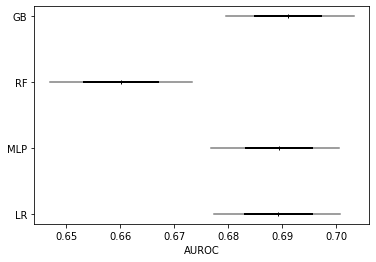

In [22]:
from helpers import plot_confidence_interval
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC" )

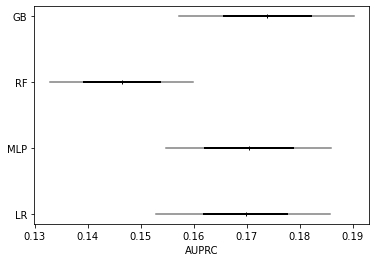

In [23]:
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC" )

In [24]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_72h_ed_revisit_disposition.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
0,age,0.082850
64,ed_los,0.080387
59,ed_heartrate_last,0.078573
62,ed_sbp_last,0.077815
63,ed_dbp_last,0.075548
58,ed_temperature_last,0.065936
66,n_medrecon,0.052547
11,triage_pain,0.049599
65,n_med,0.043092
61,ed_o2sat_last,0.038917
